In [1]:
using JLD
using PyPlot
using Statistics, StatsBase #mean and std

In [2]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP) #cuantos cuadros hay

2000

In [3]:
DatosCMP[1337]

0×3 Array{Int64,2}

In [4]:
DatosCMP[1341]

0×3 Array{Int64,2}

In [5]:
function leeunmegaarrayarchivos(NomineGeneralis::AbstractString, desde=35, hasta=501)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
            readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
    end


function leunjlddeCM(datos, desde=1, hasta=300)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
        readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end



leunjlddeCM (generic function with 3 methods)

Para Evocados, hay un par de variables temporales para considerar:
- retrazo: el tiempo en cuadros que hubo desde el comienzo del registro hasta el estimulo
- latencia: el tiempo en cuadros que hubo desde el estimulo hasta que paso algo interesante


In [6]:
freq=7.022 # la frecuencia de muestreo en kHz de los experimentos viejos

if evocada
    retms=5.0 #retrazo en milisec
    latms=4.0 #latencia en milisec
    retrazo=round(Int, retms * freq)
    lat=round(Int, latms * freq)
    desde=retrazo+lat
    hasta=300
else
    retms=0
    latms=0
    retrazo=0
    lat=0
    desde=1
    hasta=nmax
end

2000

In [7]:
function dist2D(x,y)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

function difgordis(x,y)
    result=abs(x-y)/max(abs(x),abs(y))
    return result
end

difgordis (generic function with 1 method)

In [8]:
difgordis(0.21,0.29)

0.27586206896551724

In [9]:
function encuentraTrayectorias(Datos, mincadena=20, mingordo=2.0, desde=1,hasta=20)

toleradist=16.0*sqrt(2)
#toldifgordis=0.33
tau=1
t=1
j=1

Catenario=Dict{Integer, Array{Any}}()
Cadena=[0 0 0 0]
tnum=1
CopiaMegaArray=deepcopy(Datos);
NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
 
        if(CopiaMegaArray[tau]==[])
            
            jmax,nada=0,0
        else
          
     jmax,nada= size(CopiaMegaArray[tau])
        end
    
        
    while j <=jmax && tau<FakeNumFrames
            
            if abs(CopiaMegaArray[tau][j,3]) > mingordo
                
            Eslabon=[transpose(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
                
                if CopiaMegaArray[tau+1]==[]
                    kmax,nada=0,0
                else
                kmax, nada= size(CopiaMegaArray[tau+1])
                end
                huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>mingordo
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[transpose(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    # veamos si funciona  mejor como dict 
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
        end 
    
    return Catenario
end

encuentraTrayectorias (generic function with 5 methods)

In [10]:
(desde, hasta)


(1, 2000)

In [11]:
pesomin=1
longmin=3

3

In [12]:
#Recuerda el segundo argumento es la longitud mínima de la cadena
@time CatenarioPositivo=encuentraTrayectorias(DatosCMP,longmin,pesomin,desde,hasta);


  1.484847 seconds (3.34 M allocations: 170.761 MiB, 12.57% gc time)


In [13]:
CatenarioNegativo=encuentraTrayectorias(DatosCMN,longmin,pesomin,desde,hasta);

In [14]:
nombreout=nombrecm[1:end-6]*"Tray-todas.jld"
nota="longitud minima fue $longmin, peso minimo fue $pesomin "
#save(nombreout, "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo, "nota", nota)

"longitud minima fue 3, peso minimo fue 1 "

In [15]:
length(CatenarioPositivo), length(CatenarioNegativo)

(121, 108)

In [16]:
CatenarioPositivo

Dict{Integer,Array{Any,N} where N} with 121 entries:
  68  => Any[41.2142 60.3885 241.072 930.0; 41.2156 60.3766 261.118 931.0; 41.2…
  2   => Any[49.9945 17.9973 645.097 266.0; 49.9955 18.001 1300.15 267.0; … ; 4…
  89  => Any[38.5199 55.0103 307.283 1015.0; 37.4064 54.7911 582.427 1016.0; … …
  11  => Any[25.9323 48.2821 496.209 598.0; 25.9971 48.1929 695.253 599.0; … ; …
  39  => Any[28.914 47.2191 533.941 712.0; 29.2141 46.7263 476.086 713.0; 29.48…
  46  => Any[38.0015 63.789 392.287 737.0; 37.4351 63.5529 490.428 738.0; … ; 3…
  85  => Any[44.7887 60.8058 215.544 1001.0; 44.8177 60.4299 458.953 1002.0; … …
  25  => Any[33.2012 58.7624 256.029 652.0; 32.4203 57.8599 544.604 653.0; … ; …
  55  => Any[28.8296 53.8535 665.979 850.0; 28.7169 53.6266 500.36 851.0; 28.55…
  42  => Any[27.561 55.4412 199.178 721.0; 27.4788 55.1945 258.495 722.0; … ; 2…
  29  => Any[39.2757 60.6051 350.989 664.0; 40.8986 60.4589 1042.1 665.0; … ; 4…
  58  => Any[38.2314 60.3883 425.495 869.0; 38.0042 60.4

In [17]:
nombreout

"/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-Tray-todas.jld"

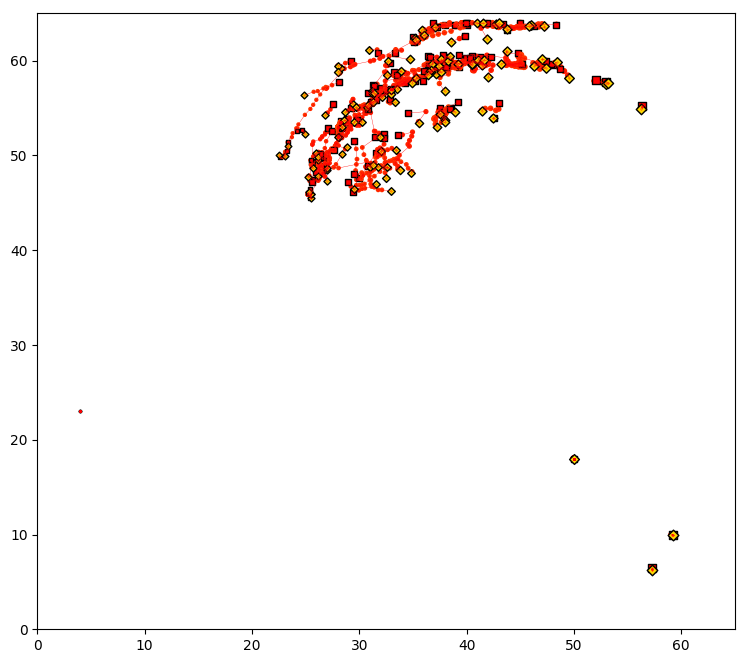

In [18]:
#PyPlot.ion()
figure(figsize=(9,8))
#axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
tolerancia=0
minlong=0
maxlong=20000
#colores=Union{}

for p in values(CatenarioPositivo)
    gordura=abs(p[:3])
    longus,gordus=size(p)
    if (mean(gordura)>tolerancia) && (longus>minlong) && longus < maxlong
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=0.25, color="r", lw=0.25, zorder=15)
        colores=scatter(xxpos,yypos, s=gordura*0.4, edgecolors="none", 
        c=tiempos, cmap="autumn", vmin=0.0, vmax=0.72 )
        principios=scatter(xxpos[1],yypos[1], s=gordura*0.5,
        edgecolors="black", 
        color="r", marker="s", label="Inicio" ,
        zorder=1)
        finales=scatter(xxpos[end],yypos[end], s=gordura*0.5, edgecolors="black", 
        color="gold", marker="D", label="Final", zorder=2 )
        # annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
        # annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end

#savefig("ejemploaltaspositivas-01.svg",dpi=92)

In [19]:
values(CatenarioNegativo)

Base.ValueIterator for a Dict{Integer,Array{Any,N} where N} with 108 entries. Values:
  Any[28.5554 46.3113 -714.531 929.0; 28.9578 46.0156 -856.178 930.0; … ; 29.78…
  Any[50.0039 18.0008 -917.67 267.0; 49.9732 17.923 -1713.13 268.0; … ; 50.0242…
  Any[30.7246 50.9782 -1126.7 1029.0; 31.0422 50.688 -978.421 1030.0; 31.4734 5…
  Any[39.8283 56.1488 -266.172 604.0; 40.2114 55.6127 -452.435 605.0; … ; 41.03…
  Any[33.548 57.0721 -5931.07 685.0; 33.0023 56.7211 -6470.82 686.0; … ; 33.895…
  Any[37.5336 60.1548 -681.125 734.0; 37.3473 59.8679 -1023.35 735.0; … ; 35.39…
  Any[23.4869 51.0987 -695.49 1016.0; 23.3474 50.8577 -434.705 1017.0; 23.3355 …
  Any[42.6766 63.7604 -781.231 635.0; 43.47 63.6696 -1144.98 636.0; … ; 45.2918…
  Any[30.345 56.1427 -277.791 819.0; 30.6349 56.2802 -619.968 820.0; … ; 31.639…
  Any[40.9981 60.2514 -186.461 713.0; 40.9919 60.0004 -247.23 714.0; 40.9854 59…
  Any[44.7594 60.4186 -258.117 654.0; 44.1248 60.3317 -523.861 655.0; … ; 40.81…
  Any[40.4171 60.0033 -

In [21]:
save(nombreout, "CatenarioPositivo", CatenarioPositivo, "CatenarioNegativo", CatenarioNegativo, "notatray", nota)